In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import keras.backend as K
from keras import Model
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/train.csv')

In [3]:
df_label_split = df_train['Image_Label'].str.split('_', expand = True)
df_label_split.columns = ["Filename", "ClassId"]
df_label_split.head()

,Filename,ClassId
0,0011165.jpg,Fish
1,0011165.jpg,Flower
2,0011165.jpg,Gravel
3,0011165.jpg,Sugar
4,002be4f.jpg,Fish


In [4]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train = df_train[['Image_Label', 'Defect','EncodedPixels']]
df_train.head()

,Image_Label,Defect,EncodedPixels
0,0011165.jpg_Fish,True,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,True,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,False,NaN
3,0011165.jpg_Sugar,False,NaN
4,002be4f.jpg_Fish,True,233813 878 235213 878 236613 878 238010 881 23...


In [5]:
df_train = pd.concat([df_train, df_label_split], axis=1, sort=False)
df_train = df_train.drop(['Image_Label'], axis=1)
df_train.head()

,Defect,EncodedPixels,Filename,ClassId
0,True,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,True,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,False,NaN,0011165.jpg,Gravel
3,False,NaN,0011165.jpg,Sugar
4,True,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


In [6]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)
df_train = df_train[['Filename', 'ClassId', 'EncodedPixels']]
df_train.head(10)

,Filename,ClassId,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg,Flower,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg,Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...
8,0031ae9.jpg,Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...
9,0031ae9.jpg,Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...
11,0031ae9.jpg,Sugar,658170 388 659570 388 660970 388 662370 388 66...
13,0035239.jpg,Flower,100812 462 102212 462 103612 462 105012 462 10...
14,0035239.jpg,Gravel,65400 380 66800 380 68200 380 69600 380 71000 ...


In [7]:
from sklearn.preprocessing import LabelEncoder

# instantiate labelencoder object
le = LabelEncoder()
df_train['ClassId'] = le.fit_transform(df_train['ClassId'])
df_train.head(10)

,Filename,ClassId,EncodedPixels
0,0011165.jpg,0,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,1,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg,0,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg,1,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg,3,67495 350 68895 350 70295 350 71695 350 73095 ...
8,0031ae9.jpg,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...
9,0031ae9.jpg,1,2047 703 3447 703 4847 703 6247 703 7647 703 9...
11,0031ae9.jpg,3,658170 388 659570 388 660970 388 662370 388 66...
13,0035239.jpg,1,100812 462 102212 462 103612 462 105012 462 10...
14,0035239.jpg,2,65400 380 66800 380 68200 380 69600 380 71000 ...


### Utility functions

In [8]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [9]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Load stored model

In [10]:
ORIG_IMG_SIZE_HEIGHT = 1400
ORIG_IMG_SIZE_WIDTH = 2100
TRAIN_IMG_SIZE_HEIGHT = 352
TRAIN_IMG_SIZE_WIDTH = 544

BATCH_SIZE = 6

NO_OF_CLASSES = 4

PATIENCE = 2
EPOCHS = 1


In [11]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [ ]:
model_350x525 = load_model('./unet_model_350x525_4classes_V4.h5', 
                          custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

In [13]:
# Binarize the mask output by NN
def binarize(masks, th = 0.5):
    # Maximum value of each channel per pixel
    mask_max = np.zeros_like(masks[:,:,0])
    mask_max = np.fmax(masks[:,:,0],masks[:,:,1])
    mask_max = np.fmax(mask_max,masks[:,:,2])
    mask_max = np.fmax(mask_max,masks[:,:,3])
    # Remove non-maximum pixels
    m = np.zeros_like(masks)
    for ch in range(4):
        m[:,:,ch] = (masks[:,:,ch] == mask_max) * masks[:,:,ch]
    # Binarization
    m = (m>th) * 1
    return m

In [14]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V1(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.latest_processed = []
        
        self.datagen_img = ImageDataGenerator(data_format='channels_last', dtype='float32')

        self.datagen_mask = ImageDataGenerator(data_format='channels_last', dtype='bool')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df)))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        

    def latest_processed(no_of_processed):
        return self.latest_processed[-no_of_processed:-1]
    
    
    def __getitem__(self, index): 
        X = np.empty((1,*self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((1, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        #indexes = self.indexes[index:(index+1)]
        
        filename = self.df['Filename'].iloc[index]
        self.latest_processed.append(filename)
        img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
        orig_img_shape = img.shape[0:2]
        if self.use_unsharp_mask:
            img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
        if orig_img_shape != self.outcome_img_shape:
            img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
        X[0,] = img

        mask = rle2mask(self.df['EncodedPixels'].iloc[index], *orig_img_shape)            
        if orig_img_shape != self.outcome_img_shape:
            mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
        y[0,:,:,(int(self.df['ClassId'].iloc[index]) - 1)] = mask
         
        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=1, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=1, shuffle=False)
        
        return zip(image_generator, mask_generator).__next__()


In [15]:
#idx = int(0.85*len(df_train))
dataGen_train_visual = ImgDataGenerator_V1(df_train.iloc[0: 5], './input/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH),
                                    n_channels=3, n_classes=4, 
                                    img_normalize=True, img_center=False, img_standardize=False,
                                    use_unsharp_mask=False, unsharp_radius=1, unsharp_amount=1)

print('Running predictions')
preds = model_350x525.predict_generator(dataGen_train_visual,verbose=1)

print(preds.shape)

Running predictions
5/5 [==============================] - 3s 570ms/step
(5, 352, 544, 4)


In [16]:
def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

IndexError: index 20 is out of bounds for axis 0 with size 20

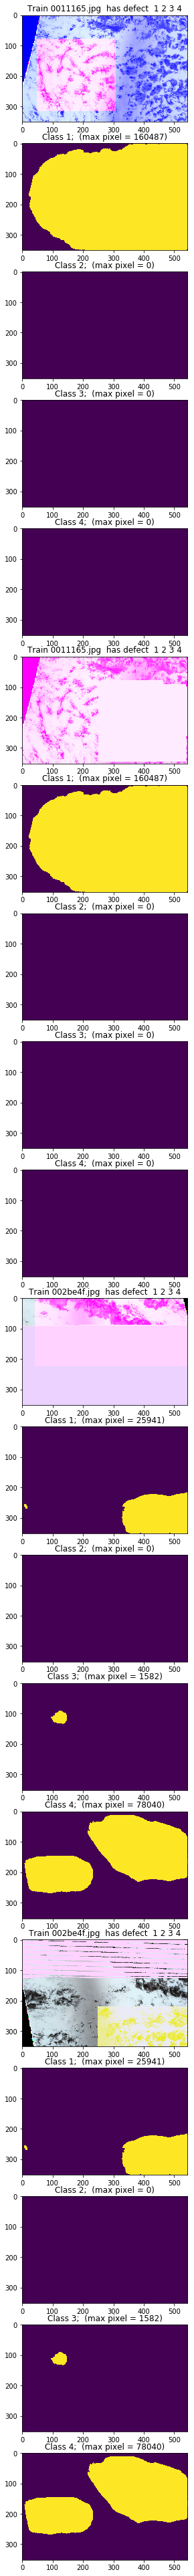

In [29]:
%%time
batch_size = 1
fig, axs = plt.subplots(20,1, figsize=(60, 70))
#plt.subplots_adjust(hspace=0.3, wspace = 0.05)

for i,batch in enumerate(dataGen_train_visual):
    if i > 15:
        break
    for k in range(batch_size):
        img = batch[0][k,]
        img = np.array(img)
        img *= 255
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            #msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        
        if extra=='  has defect ': extra =''
        
        axs[i*5].imshow(Image.fromarray(img.astype('uint8')))
        axs[i*5].set_title('Train ' + df_train.iloc[batch_size*i+k,0]+extra)
        
        msk = preds[batch_size*i+k,...]
        msk = binarize(msk, 0.5)
        for j in range(4):
            axs[i*5+1+j].imshow(msk[:,:,j])
            mx = np.round(np.sum(msk[:,:,j]),3)
            axs[i*5++j].set_title('Class ' + str(j+1) + ';  (max pixel = ' + str(mx)+ ')')



FileName: 0011165.jpg, Class: 0, Index: 0
FileName: 0011165.jpg, Class: 1, Index: 1
FileName: 002be4f.jpg, Class: 0, Index: 2
FileName: 002be4f.jpg, Class: 1, Index: 3
FileName: 002be4f.jpg, Class: 3, Index: 4


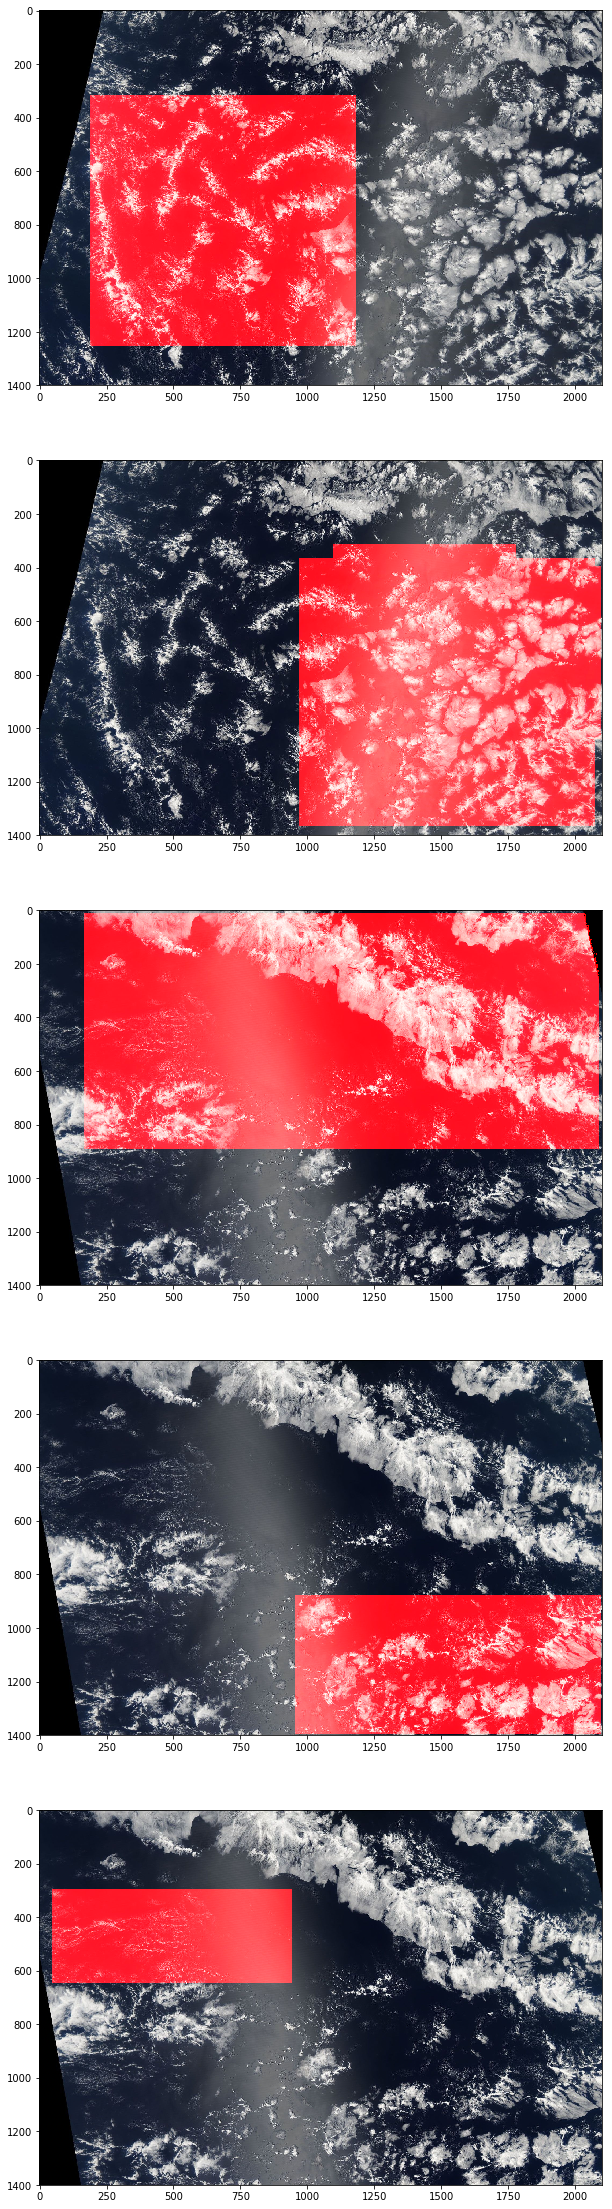

In [46]:
rows = 5
fig = plt.figure(figsize=(40, 40))
for i in range(0, rows):
    fn = df_train['Filename'].iloc[i]
    c = df_train['ClassId'].iloc[i]
    print(f'FileName: {fn}, Class: {c}, Index: {i}')
    fig.add_subplot(rows, 1, i + 1)
    img = cv2.imread( './input/train_images/' + fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape[0], img.shape[1])
    img[mask==1,0] = 255
    plt.imshow(img)

plt.show()


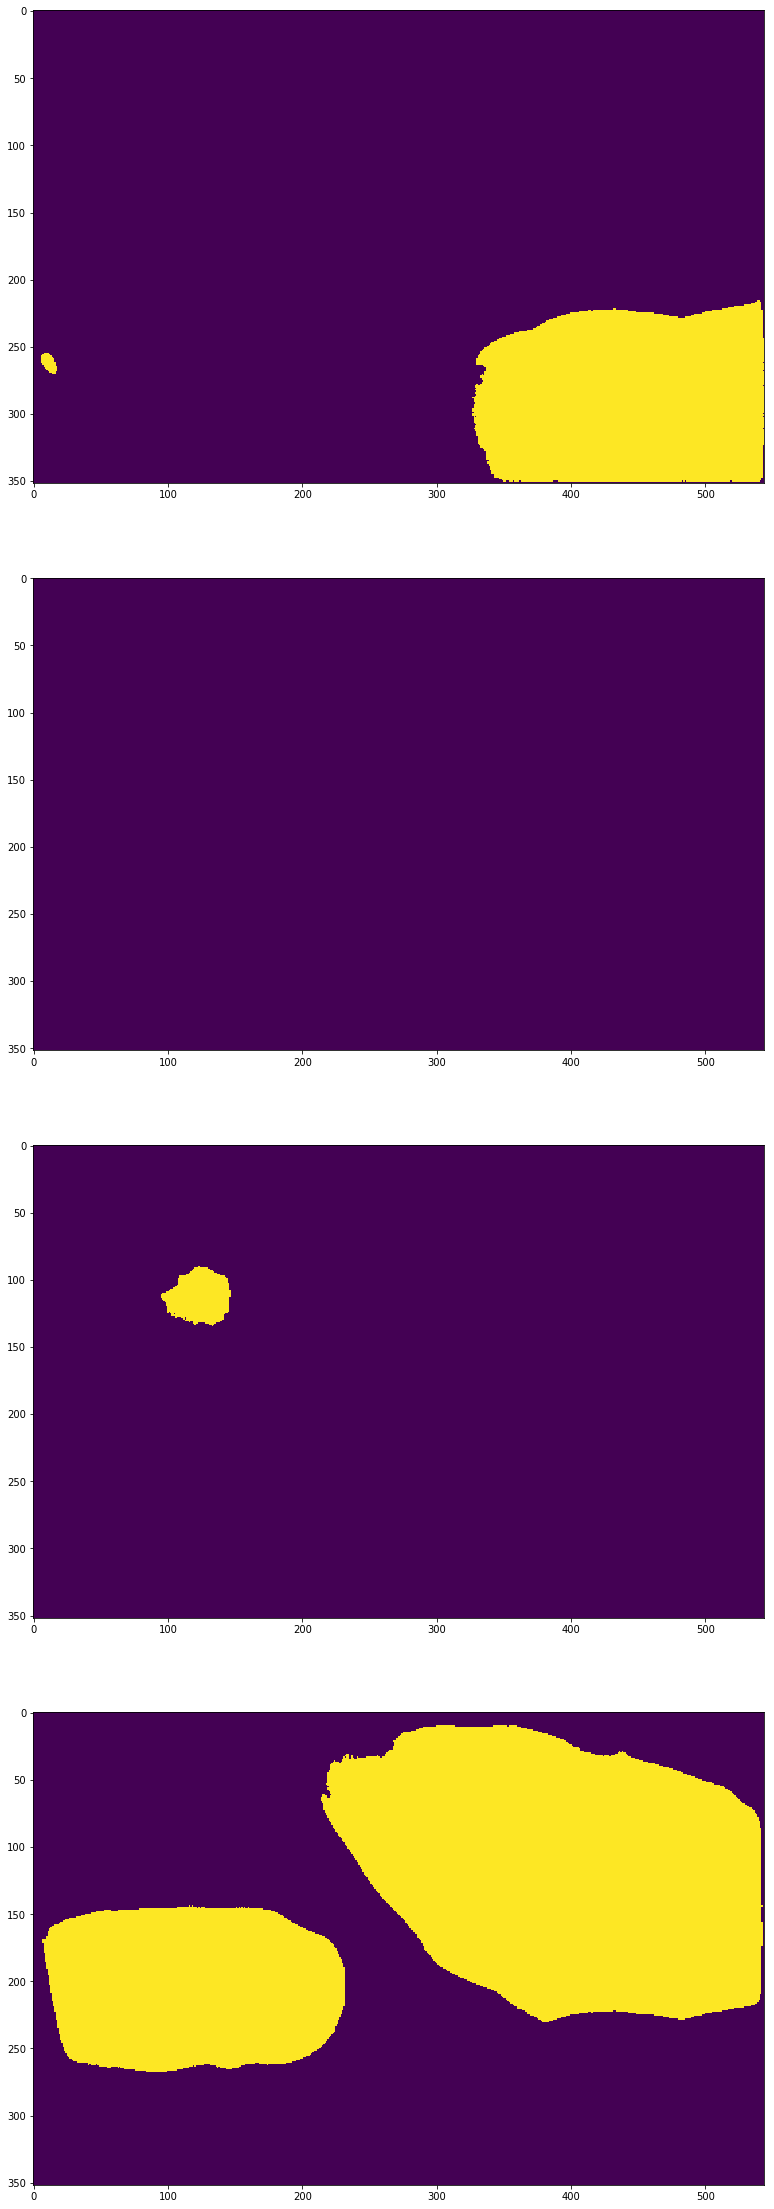

In [45]:
rows = 4
fig = plt.figure(figsize=(40, 40))

msk = preds[3,...]
msk = binarize(msk, 0.5)
for j in range(4):
    fig.add_subplot(rows, 1, j + 1)
    plt.imshow(msk[:,:,j])

plt.show()


#### Create submission file

In [ ]:
df_submission = pd.read_csv('./input/severstal-steel-defect-detection/sample_submission.csv')
df_submission.head(10)

In [ ]:
df_test = df_submission.copy()

df_test['ClassId'] = df_test['ImageId_ClassId'].str[-1:]
df_test['ImageId'] = df_test['ImageId_ClassId'].str[:-2]

df_test = df_test[['ImageId']].drop_duplicates()
print(df_test.shape)

In [ ]:
df_test.head()

In [ ]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_predictor(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.latest_processed = []
        
        self.datagen_img = ImageDataGenerator(data_format='channels_last', dtype='float32')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df)))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        

    def latest_processed(no_of_processed):
        return self.latest_processed[-no_of_processed:-1]
    
    
    def __getitem__(self, index): 
        X = np.empty((1,*self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((1, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        filename = self.df['ImageId'].iloc[index]
        self.latest_processed.append(filename)
        img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
        orig_img_shape = img.shape[0:2]
        if self.use_unsharp_mask:
            img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
        if orig_img_shape != self.outcome_img_shape:
            img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
        X[0,] = img

        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=1, shuffle=False)
        
        return image_generator.__next__()


In [ ]:
dataGen_train_visual_sub = ImgDataGenerator_predictor(df_test.iloc[0: 100], './input/severstal-steel-defect-detection/test_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH),
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5)

print('Running predictions')
preds_sub = model_128x800.predict_generator(dataGen_train_visual_sub,verbose=1)

print(preds_sub.shape)

In [ ]:
print(df_test.shape)
print(df_submission.shape)

In [ ]:
#%%time
for index in range(df_test.head(100).shape[0]): #df_test.head(10).iterrows():
    #print(index)
    msk = preds_sub[index]
    msk = binarize(msk, 0.5)
    for j in range(4):
        msk_sum = np.round(np.sum(msk[:,:,j]),3)
        if msk_sum > 10:
            print(str(msk_sum) + ' || ' + df_test.iloc[index])
            rle = mask2rle(msk[:,:,j])
            df_submission.iloc[4*index + j].EncodedPixels = rle
        else:
            df_submission.iloc[4*index + j].EncodedPixels = ''
            print('NO DEFECT || ' + df_test.iloc[index])
            
            

In [ ]:
df_submission.head(100)

In [ ]:
df_test.head(10)

In [ ]:
df_submission.to_csv('submission.csv', index=False)